# Nanocrystal Segmentation

This notebook demonstrates two approaches to nanocrystal segmentation:
1. Virtual dark-field (VDF) imaging-based segmentation
2. Non-negative matrix factorisation (NMF)-based segmentation

The segmentation is demonstrated on a SPED dataset of partly overlapping MgO nanoparticles, where some of the particles share the same orientation.

This functionality has been checked to run with pyxem-0.11.0 (May 2020). Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

## Contents

1. <a href='#gen'> Setting up, Loading Data, Pre-processing</a>
2. <a href='#vdf'> Virtual Image Based Segmentation</a>
3. <a href='#nmf'> NMF Based Segmentation</a>

<a id='gen'></a>
## 1. Setting up, Loading Data, Pre-processing

Import pyxem and other required libraries

In [1]:
%matplotlib inline
import numpy as np
import hyperspy.api as hs
import matplotlib.pyplot as plt
import pyxem as pxm

/home/carter/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/carter/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

Load demonstration data

In [2]:
dp = hs.load('./data/06/mgo_nanoparticles.hdf5')

In [3]:
dp

<ElectronDiffraction2D, title: , dimensions: (54, 57|72, 72)>

Plot data to inspect

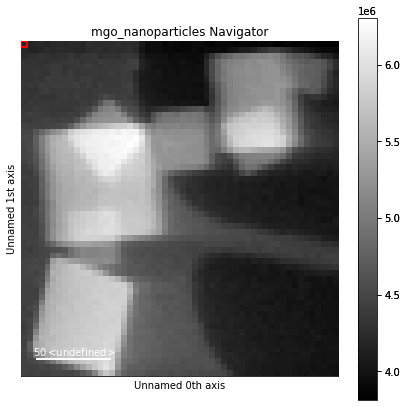

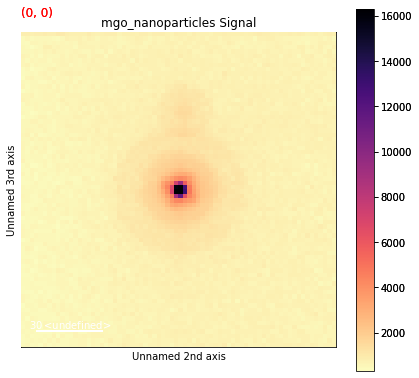

In [4]:
dp.plot(cmap='magma_r')

Remove the background

In [5]:
sigma_min = 1.7
sigma_max = 13.2

dp_rb= dp.subtract_diffraction_background('difference of gaussians', 
                             min_sigma=sigma_min, 
                             max_sigma=sigma_max)

In [6]:
dp.data

array([[[[820., 851., 813., ..., 791., 815., 786.],
         [465., 603., 463., ..., 507., 672., 475.],
         [497., 428., 591., ..., 709., 665., 567.],
         ...,
         [415., 502., 414., ..., 559., 577., 588.],
         [381., 470., 535., ..., 501., 755., 579.],
         [449., 532., 423., ..., 678., 675., 654.]],

        [[739., 779., 722., ..., 730., 753., 794.],
         [666., 434., 470., ..., 626., 628., 553.],
         [594., 528., 621., ..., 522., 483., 571.],
         ...,
         [502., 550., 564., ..., 630., 610., 591.],
         [523., 478., 577., ..., 670., 652., 640.],
         [443., 541., 442., ..., 624., 695., 691.]],

        [[718., 763., 686., ..., 746., 816., 790.],
         [514., 524., 429., ..., 619., 644., 647.],
         [604., 572., 612., ..., 536., 631., 534.],
         ...,
         [556., 386., 529., ..., 507., 717., 555.],
         [380., 487., 507., ..., 643., 791., 611.],
         [494., 534., 474., ..., 713., 574., 595.]],

        ...,

  

In [7]:
dp_rb.data.compute()

array([[[[211.09319  , 241.5881   , 202.57956  , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         ...,
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ]],

        [[145.28221  , 184.74947  , 126.6862   , ...,   0.       ,
            0.       ,   0.       ],
         [ 72.242386 ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         ...,
         [  0.       ,   0.       

Plot the background subtracted data

[########################################] | 100% Completed |  0.8s


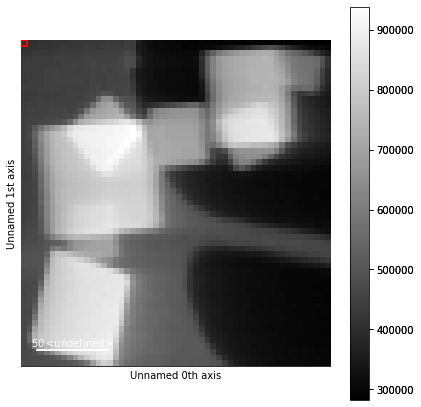

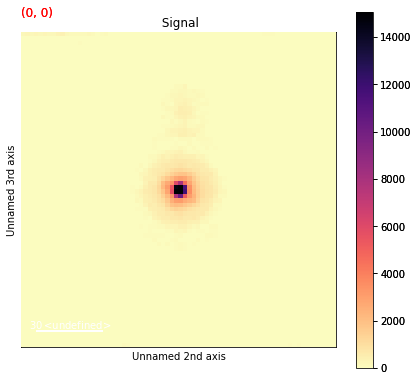

In [8]:
dp_rb.plot(cmap='magma_r')


Find the position of the direct beam in the background subtracted data.

In [9]:
shifts = dp_rb.center_direct_beam(method='cross_correlate',
                                  half_square_width=15,
                                  return_shifts=True,
                                  radius_start=2,
                                  radius_finish=6)

In [10]:
# this step is likely to be quiet slow
shifts.compute()

[########################################] | 100% Completed | 24.7s


Apply the same shifts to the raw data.

In [ ]:
dp_rb.align2D(shifts=shifts, crop=False)

Set calibrations

In [ ]:
scale = 0.03246*2 
scale_real = 3.03*2
dp.set_diffraction_calibration(scale)
dp.set_scan_calibration(scale_real)

In [ ]:
# see https://github.com/pyxem/pyxem/issues/717 for why have to do this
dp_rb.compute()
dp_rb = pxm.signals.ElectronDiffraction2D(dp_rb)

dp_rb.set_diffraction_calibration(scale)
dp_rb.set_scan_calibration(scale_real)

<a id='vdf'></a>
##  2. Virtual Image Based Segmentation

### 2.1. Peak Finding & Refinement

Find all diffraction peaks for all PED patterns. 
The parameters were found by interactive peak finding:

`peaks = dp_rb.find_peaks_interactive(imshow_kwargs={'cmap': 'magma_r'})`

In [ ]:
import hyperspy
hyperspy.__version__

In [ ]:
#This is broken, see https://github.com/hyperspy/hyperspy/issues/262
peaks = dp_rb.find_peaks(method='difference_of_gaussian', 
                         min_sigma=0.7,
                         max_sigma=10,
                         num_sigma=20, 
                         threshold=0.046, 
                         overlap=0.5, 
                         log_scale=False,
                         exclude_border=True)

Visualise the number of diffraction peaks found at each probe position

In [ ]:
peaks

In [ ]:
diff_map = peaks.get_diffracting_pixels_map()
diff_map.plot()

Exclude peaks too close to the detector edge for sub-pixel refinement. 

In [ ]:
peaks_filtered = peaks.filter_detector_edge(exclude_width=2)

Refine the peak positions using center of mass

In [ ]:
from pyxem.generators.subpixelrefinement_generator import SubpixelrefinementGenerator
from pyxem.signals.diffraction_vectors import DiffractionVectors


refine_gen = SubpixelrefinementGenerator(dp_rb, peaks_filtered)

peaks_refined = DiffractionVectors(refine_gen.center_of_mass_method(square_size=4))

peaks_refined.axes_manager.set_signal_dimension(0)

### 2.2. Determine Unique Peaks

Determine the unique diffraction peaks by clustering

In [ ]:
distance_threshold = scale*0.89
min_samples = 10

unique_peaks = peaks_refined.get_unique_vectors(method='DBSCAN',
                                                distance_threshold=distance_threshold,
                                                min_samples=min_samples)
print(np.shape(unique_peaks.data)[0], ' unique vectors were found.')

Visualise the detected unique peaks by plotting them on the maximum of the signal. 

In [ ]:
radius_px = dp_rb.axes_manager.signal_shape[0]/2
reciprocal_radius = radius_px * scale

In [ ]:
unique_peaks.plot_diffraction_vectors(
    method='DBSCAN',
    unique_vectors=unique_peaks,
    distance_threshold=distance_threshold,
    xlim=reciprocal_radius,
    ylim=reciprocal_radius,
    min_samples=min_samples,
    image_to_plot_on=dp_rb.max(),
    image_cmap='magma_r',
    plot_label_colors=False)

Visualise both the clusters and the unique peaks obtained after DBSCAN clustering. 

*NB The cluster colors are randomly generated, so run it again if it is hard to discern two close clusters.*

In [ ]:
peaks_refined.plot_diffraction_vectors(
    method='DBSCAN',
    xlim=reciprocal_radius, 
    ylim=reciprocal_radius,
    unique_vectors=unique_peaks, 
    distance_threshold=distance_threshold,
    min_samples=min_samples, 
    image_to_plot_on=dp_rb.max(), 
    image_cmap='gray_r',
    plot_label_colors=True, 
    distance_threshold_all=scale*0.1)

Filter the unique vectors by magnitude in order to exclude the direct beam from the following analysis

In [ ]:
Gs = unique_peaks.filter_magnitude(min_magnitude=10*scale,
                                   max_magnitude=np.inf)
print(np.shape(Gs)[0], ' unique vectors.')

Plot the unique vectors

In [ ]:
Gs.plot_diffraction_vectors(unique_vectors=Gs,
                            distance_threshold=distance_threshold,
                            xlim=reciprocal_radius,
                            ylim=reciprocal_radius,
                            min_samples=min_samples,
                            image_to_plot_on=dp_rb.max(),
                            image_cmap='magma',
                            plot_label_colors=False)

Optionally save and load the unique peaks

In [ ]:
np.save('peaks.npy', Gs.data)

In [ ]:
Gs = np.load('peaks.npy', allow_pickle=True)
Gs = pxm.DiffractionVectors(Gs)
Gs.axes_manager.set_signal_dimension(0)

### 2.3. Virtual Imaging & Segmentation

Calculate VDF images for all unique peaks

In [ ]:
from pyxem.generators.vdf_generator import VDFGenerator

radius=scale*2

vdfgen = VDFGenerator(dp_rb, Gs)
VDFs = vdfgen.get_vector_vdf_images(radius=radius)

Plot the VDF images for inspection

In [ ]:
VDFs.plot(cmap='magma', scalebar=False)

First find adequate parameters by looking at watershed segmentation of a single VDF image.

In [ ]:
from pyxem.utils.segment_utils import separate_watershed

In [ ]:
min_distance = 5.5
min_size = 10
max_size = 1000
max_number_of_grains = 1000
marker_radius = 2
exclude_border = 2

In [ ]:
i = 25
sep_i = separate_watershed(
    VDFs.inav[i].data, min_distance=min_distance, min_size=min_size,
    max_size=max_size, max_number_of_grains=max_number_of_grains,
    exclude_border=exclude_border, marker_radius=marker_radius,
    threshold=True, plot_on=True)

Perform segmentation on all the VDF images

In [ ]:
segs = VDFs.get_vdf_segments(min_distance=min_distance,
                             min_size=min_size,
                             max_size = max_size,
                             max_number_of_grains = max_number_of_grains,
                             exclude_border=exclude_border,
                             marker_radius=marker_radius,
                             threshold=True)

print(np.shape(segs.segments)[0],' segments were found.')

Plot the segments for inspection

In [ ]:
segs.segments.plot(cmap='magma_r')

Calculate normalised cross-correlations between all VDF image segments to identify those that are related to the same crystal.

In [ ]:
ncc_vdf = segs.get_ncc_matrix()
ncc_vdf.plot(scalebar=False, cmap='RdBu')

If the correlation value exceeds *corr_threshold* for certain segments, those segments are summed. These segments are discarded if the number of these segments are below *vector_threshold*, as this number corresponds to the number of detected diffraction peaks associated with the single crystal. The *vector_threshold* criteria is included to avoid including segment images resulting from noise or incorrect segmentation. 

In [ ]:
corr_threshold=0.7
vector_threshold=5
segment_threshold=4

In [ ]:
corrsegs = segs.correlate_vdf_segments(
    corr_threshold=corr_threshold, vector_threshold=vector_threshold,
    segment_threshold=segment_threshold)
print(np.shape(corrsegs.segments)[0],' correlated segments were found.')

Simulate virtual diffraction patterns for each summed segment

In [ ]:
sigma = scale*1.5

virtual_sig = corrsegs.get_virtual_electron_diffraction(
    calibration=scale, shape=(int(radius_px*2), int(radius_px*2)), sigma=sigma)
virtual_sig.set_diffraction_calibration(scale)

Plot the final results from the VDF image-based segmentation

In [ ]:
hs.plot.plot_images(corrsegs.segments, cmap='magma_r', axes_decor='off',
                    per_row=np.shape(corrsegs.segments)[0],
                    suptitle='', scalebar=False, scalebar_color='white',
                    colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})
hs.plot.plot_images(virtual_sig, cmap='magma_r', axes_decor='off',
                    per_row=np.shape(corrsegs.segments)[0],
                    suptitle='', scalebar=False, scalebar_color='white',
                    colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right': 0.78})

<a id='nmf'></a> 
## 3. NMF Based Segmentation

### 3.1. NMF Decomposition

Create a signal mask so that the region in the centre of each PED pattern, including the direct beam, can be excluded in the machine learning. 

In [ ]:
dpm = pxm.Diffraction2D(dp.inav[0,0])
signal_mask = dpm.get_direct_beam_mask(radius=10)
signal_mask.plot()

Perform single value decomposition (SVD)

In [ ]:
dp.change_dtype('float32')
dp.decomposition(algorithm='svd',
                 normalize_poissonian_noise=True,
                 centre='variables',
                 signal_mask=signal_mask.data)

In [ ]:
dp.plot_decomposition_results()

Investigate the scree plot and use it as a guide to determine the number of components

In [ ]:
num_comp=11

ax = dp.plot_explained_variance_ratio(n=200, threshold=num_comp,
                                      hline=True, xaxis_labeling='ordinal',
                                      signal_fmt={'color':'k', 'marker':'.'}, 
                                      noise_fmt={'color':'gray', 'marker':'.'})

Perform NMF decomposition with specified number of components

In [ ]:
dp.decomposition(normalize_poissonian_noise=True,
                 algorithm='nmf',
                 output_dimension=num_comp,
                 signal_mask=signal_mask.data)

In [ ]:
dp_nmf = dp.get_decomposition_model(components=np.arange(num_comp))
factors = dp_nmf.get_decomposition_factors()
loadings = dp_nmf.get_decomposition_loadings()

Plot the NMF results

In [ ]:
hs.plot.plot_images(loadings, cmap='magma_r', axes_decor='off', per_row=11,
             suptitle='', scalebar=False, scalebar_color='white', colorbar=False,
             padding={'top': 0.95, 'bottom': 0.05,
                      'left': 0.05, 'right':0.78})
hs.plot.plot_images(factors, cmap='magma_r', axes_decor='off', per_row=11,
             suptitle='', scalebar=False, scalebar_color='white', colorbar=False,
             padding={'top': 0.95, 'bottom': 0.05,
                      'left': 0.05, 'right':0.78})

Discard the components related to background (\#0) and to the carbon film (\#4)

In [ ]:
from hyperspy.signals import Signal2D

In [ ]:
factors = Signal2D(np.delete(factors.data, [0, 4], axis = 0))
loadings = Signal2D(np.delete(loadings.data, [0, 4], axis = 0))

In [ ]:
hs.plot.plot_images(factors, cmap='magma_r', axes_decor='off',
                    per_row=9, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

hs.plot.plot_images(loadings, cmap='magma_r', axes_decor='off',
                    per_row=9, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

### 3.2. Correlate NMF Loading Maps

NMF often leads to splitting of some crystals into several components. Therefore the correlation between loadings and between component patterns are calculated, and if both the correlation values for loadings and factors exceed threshold values, those loadings and factors are summed. 

Calculate the matrix of normalised cross-correlation for both the loadings and patterns first, to find suitable correlation threshold values. 

In [ ]:
from pyxem.signals.segments import LearningSegment
learn = LearningSegment(factors=factors, loadings=loadings)

In [ ]:
ncc_nmf = learn.get_ncc_matrix()

In [ ]:
ncc_nmf.plot(scalebar=False, cmap='RdBu')

In [ ]:
corr_th_factors = 0.45
corr_th_loadings = 0.3

Perform correlation and summation of the factors and loadings

In [ ]:
learn_corr = learn.correlate_learning_segments(corr_th_factors=corr_th_factors,
                                               corr_th_loadings=corr_th_loadings)

Plot the NMF reuslts after correlation and summation

In [ ]:
hs.plot.plot_images(learn_corr.loadings, cmap='magma_r', axes_decor='off',
                    per_row=7, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})
hs.plot.plot_images(learn_corr.factors, cmap='magma_r', axes_decor='off',
                    per_row=7, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

First investigate how the parameters influence the segmentation on
one single loading map.

In [ ]:
from pyxem.utils.segment_utils import separate_watershed

In [ ]:
min_distance = 10
min_size = 50
max_size = 100000
max_number_of_grains = 100000
marker_radius = 2
exclude_border = 1
threshold = True

In [ ]:
i =1
sep_i = separate_watershed(
    learn_corr.loadings.data[i], min_distance=min_distance,
    min_size=min_size, max_size=max_size, 
    max_number_of_grains=max_number_of_grains,
    exclude_border=exclude_border, 
    marker_radius=marker_radius, threshold=True, plot_on=True)

Set a threshold for the minimum intensity value that a loading segment must contain in order to be kept. 

In [ ]:
min_intensity_threshold = 10000

In [ ]:
learn_corr_seg = learn_corr.separate_learning_segments(
    min_intensity_threshold=min_intensity_threshold,
    min_distance = min_distance, min_size = min_size,
    max_size = max_size, 
    max_number_of_grains = max_number_of_grains,
    exclude_border = exclude_border,
    marker_radius = marker_radius, threshold = True)

Plot the final results from the NMF-based segmentation

In [ ]:
hs.plot.plot_images(learn_corr_seg.loadings, 
                    cmap='magma_r', axes_decor='off',
                    per_row=10, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

hs.plot.plot_images(learn_corr_seg.factors, 
                    cmap='magma_r', axes_decor='off',
                    per_row=10, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})